

# Developing Fair Classifiers: A case study using COMPAS data

## Introduction

##### There are many different ways to measure fairness in AI. As such, there are many ways to adjust your AI models so that they better fit these fairness metrics. Here, you will examine this firsthand with the COMPAS dataset, which is a dataset that has been widely used to predict inmates' likelihood of recidivism (reoffense). First, you will run a simple classifier on this dataset and examine the results. Then, you will be asked how this classifier could be made more fair and, for extra credit, you can try implementing these changes yourself.


## Dataset exploration

##### First, you will run the cells and answer the questions below in order to explore the contents of the dataset

### Imports

In [2]:
#uncomment these lines if you need to install either of these two packages

!pip3 install plotly
!pip3 install 'aif360[LFR]'
!pip install aif360==0.2.3
!pip install 'aif360[AdversarialDebiasing]'

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
You should consider upgrading via the 'pip install --upgrade pip' command.
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io

In [3]:
import urllib
import urllib.request
import os,sys
import numpy as np
import pandas as pd
from functools import reduce
pd.set_option('display.max_columns',None)
from pprint import pprint
import matplotlib.pyplot as plt
import sklearn.metrics as performance
from sklearn.preprocessing import scale
from random import seed, shuffle
from IPython.display import Markdown, display

%matplotlib inline

try:
    import plotly.express as px
    import plotly.figure_factory as ff
    import plotly.io as pio
    import plotly.graph_objects as go
    pio.renderers.default = "notebook_connected" #change to "colab" if using Google Colab, or "notebook" if offline
except ImportError as e:
#     !conda install --yes --prefix {sys.prefix} -c plotly plotly-orca==1.2.1 psutil requests
    print("plotly is not installed !! please install the package to be able to render plotly visualizations")


try:
    from aif360.metrics import BinaryLabelDatasetMetric
    from aif360.metrics import ClassificationMetric
    from aif360.metrics.utils import compute_boolean_conditioning_vector
    from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing

    from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                    import load_preproc_data_compas
    
except ImportError as e:
    print('please install aif360 package to proceed with the fairness section')
    


### Setting up visualization properties

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
fig=plt.figure(figsize=(10,6))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



<Figure size 720x432 with 0 Axes>

### UTILS

In [5]:
def hist(column_name, x):
    '''
    helper function to plot historgram for a dataframe 
    '''
    return px.histogram(column_name, x = x,
                       title = x,
                       opacity = 0.8,
                       color_discrete_sequence = ['indianred'])
def plot_roc(fpr,tpr,thresholds=None,label=None):
    '''
    plot roc curve for multiple instances.
    '''
    
    colors = ['red','blue','aqua', 'darkorange', 'cornflowerblue', 'burlywood', 'lightsalmon', 'olive']

    plt.figure(figsize=(12,8))
    lw = 2
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], color=colors[i],label=label[i],
             lw=lw)
        
     
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
      
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of attributes ')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.show()


#for each race/decile pair, calculate stats for recidivism
def recid_count_fn(df_recid_column):
    """ Computes the total number of examples in which recidivism occurred.
        Parameters:
            df_recid_column: DataFrame column where each row takes value 1 if
            recidivism occured, and 0 if recidivism did not occur.
        Returns:
            The total number of examples in which recidivism occurred.
    """
    recid_count = df_recid_column.sum()
    return recid_count

def non_recid_count_fn(df_recid_column):
    """Computes the total number of examples in which recidivism did not occur.
    Parameters:
        df_recid_column: dataframe column where each row takes value 1 if
        recidivism occured, and 0 if recidivism did not occur.
    Returns:
        The total number of examples in which recidivism did not occur.
    """
    non_recid_count = sum(df_recid_column == 0) 
    return non_recid_count

def total_count_fn(df_recid_column):
    """Computes the total number of examples in the dataset.
    Parameters:
        df_recid_column: dataframe column where each row takes value 1 if
        recidivism occured, and 0 if recidivism did not occur.
    Returns:
        The total number of examples in the dataset.
    """
    total_count = df_recid_column.count()
    return total_count


#compute the classifier outcomes for different decision thresholds (using summary DataFrame above)
#often in statistics, we can express the probabilities in the introduction in terms of true positive rate, 
#true negative rate, false positive rate, and false negative rate
def TP(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of true positives for each decile_score. We classify an example as 1 if 
            that example's score is equal to or above the decision threshold. Take recid_count. 
    """
    TPs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] >= threshold]['recid_count'].sum()
        true_positives = x
        TPs.append(true_positives)
    return np.array(TPs, dtype=np.int32)

def FP(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of false positives for each decile_score. We classify an example as 1 if 
            that example's score is equal to or above the decision threshold. Take non_recid_count. 
    """
    FPs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] >= threshold]['non_recid_count'].sum()
        false_positives = x
        FPs.append(false_positives)
    return np.array(FPs, dtype=np.int32)

def TN(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of true negatives for each decile_score. We classify an example as 1 if 
            that example's score less than the decision threshold. Take non_recid_count. 
    """
    TNs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] < threshold]['non_recid_count'].sum()
        true_negatives = x
        TNs.append(true_negatives)
    return np.array(TNs, dtype=np.int32)

def FN(compas_stats_df):
    """
        Args:
            compas_stats_df: DataFrame found above
        Returns:
            An array of the number of true positives for each decile_score. We classify an example as 1 if 
            that example's score is equal to or above the decision threshold. Take recid_count. 
    """
    FNs = []
    for threshold in compas_stats_df['decile_score']:
        x = compas_stats_df[compas_stats_df['decile_score'] < threshold]['recid_count'].sum()
        false_negatives = x
        FNs.append(false_negatives)
    return np.array(FNs, dtype=np.int32)



### Download data file and dependency files

In [6]:
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file %s in the current directory..." % (fname))

    if fname not in files:
        print(" %s not found! Downloading from GitHub..." % fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("%s download and saved locally.." % fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file compas-scores-two-years.csv in the current directory...
 compas-scores-two-years.csv not found! Downloading from GitHub...
compas-scores-two-years.csv download and saved locally..


### Load and clean data

In [7]:
dataset = pd.read_csv(COMPAS_INPUT_FILE)

dataset = dataset.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

dataset = dataset[ (dataset.days_b_screening_arrest <= 30) &
(dataset.days_b_screening_arrest >= -30) &
(dataset.is_recid != -1) & (dataset.c_charge_degree != 'O') & (dataset.score_text != 'N/A') ]

dataset.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

In [8]:
dataset.head(10)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
5,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
6,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
7,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,0,4,0,0,0,-1.0,2013-11-25 06:31:06,2013-11-26 08:26:57,13016402CF10A,2013-11-25,NaN,1.0,F,"Poss 3,4 MDMA (Ecstasy)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-11-26,Risk of Violence,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
8,15,ellyaher lanza,ellyaher,lanza,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,0,6,0,0,3,0.0,2013-10-03 04:07:35,2013-10-07 08:17:30,13018837MM10A,2013-10-03,NaN,0.0,M,Battery,1,14010414TC40A,(M2),NaN,2014-02-08,Driving License Suspended,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2013-10-03,Risk 

### Basic analysis of demographics
A series of plots is given below which look at the distribution of the data, the decile scores (the scores in the COMPAS dataset that measure likelihood of reoffense), and the risk category, which is based on the decile score and is determined in the following manner:

 1 – 4: scale score is low relative to other offenders in norm group.

 5 – 7: scale score is medium relative to other offenders in norm group.

 8 – 10: scale score is high relative to other offenders in norm group.


After looking at the plots, you will be asked to describe the imbalances of the dataset

In [9]:
def get_basic_stats(column_name,check_values=None,
                    check_NaN=False,group_count=True,plot_hist = False):
    '''
    basic stats on a given column of the dataset
    @param column_name: column name to compute stats on
    '''
    
    result = {}
    
    if column_name not in dataset.columns:
        raise ValueError("column_name must be set to a value from the the available values")
        
    #values in the column
    column_values = np.unique(dataset[column_name].values)
    
    if check_values:
        print('-',column_name,"in dataset:")
        [print(value) for value in column_values]

    if check_NaN:
        print("-NaN  present in the column?",dataset[column_name].isnull().any())
    
    if group_count:
        values_count = dataset[column_name].value_counts()   
        result.update(values_count=values_count)
        
    #histogram of values
    if plot_hist:
        fig = hist(dataset[column_name], column_name) 
        fig.show()        
    
    return result

In [10]:
result = get_basic_stats("race",plot_hist=True)

In [11]:
result = get_basic_stats("age", plot_hist=True)

In [12]:
sex_race_df = pd.crosstab(dataset.race, dataset.sex)
sex_race_df = sex_race_df.stack().reset_index().rename(columns={0:"value"})

In [13]:
race = np.sort(dataset.race.unique())
males = sex_race_df.value[sex_race_df.sex == 'Male']
females = sex_race_df.value[sex_race_df.sex == 'Female']

fig = go.Figure(data=[
    go.Bar(name='Male', x=race, y= males),
    go.Bar(name='Female', x=race, y=females)
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [14]:
decile_score_per_race = pd.crosstab(dataset.decile_score, dataset.race)
decile_score_per_race = decile_score_per_race.stack().reset_index().rename(columns = {0:'values'})

In [15]:
dec_score = dataset.decile_score.unique()
afrac_amer = decile_score_per_race.values[decile_score_per_race.race == "African-American"][:,2]
hispanic = decile_score_per_race.values[decile_score_per_race.race == "Hispanic"][:,2]
asian = decile_score_per_race.values[decile_score_per_race.race == "Asian"][:,2]
causcasian = decile_score_per_race.values[decile_score_per_race.race == "Caucasian"][:,2]
native = decile_score_per_race.values[decile_score_per_race.race == "Native American"][:,2]
other = decile_score_per_race.values[decile_score_per_race.race == "Other"][:,2]

fig = go.Figure(data = [
    go.Bar(name = 'African-American', x = dec_score, y = afrac_amer),
    go.Bar(name = 'Hispanic', x = dec_score, y = hispanic),
    go.Bar(name = 'Asian', x = dec_score, y = asian),
    go.Bar(name = 'Causcasian', x = dec_score, y = causcasian),
    go.Bar(name = 'Native-American', x = dec_score, y = native),
    go.Bar(name = 'Other', x = dec_score, y = other)
])
fig.update_layout(barmode='stack')
fig.show()

The *low*, *medium* and *high* values below are categories for risk based on the **decile_score** computed. This will be discussed in more detail in the upcoming sections.

In [16]:
score_text_per_race = pd.crosstab(dataset.score_text, dataset.race)
score_text_per_race = score_text_per_race.stack().reset_index().rename(columns = {0:'values'})

In [17]:
dec_score = dataset.score_text.unique()
afrac_amer = score_text_per_race.values[score_text_per_race.race == "African-American"][:,2]
hispanic = score_text_per_race.values[score_text_per_race.race == "Hispanic"][:,2]
asian = score_text_per_race.values[score_text_per_race.race == "Asian"][:,2]
causcasian = score_text_per_race.values[score_text_per_race.race == "Caucasian"][:,2]
native = score_text_per_race.values[score_text_per_race.race == "Native American"][:,2]
other = score_text_per_race.values[score_text_per_race.race == "Other"][:,2]

fig = go.Figure(data = [
    go.Bar(name = 'African-American', x = dec_score, y = afrac_amer),
    go.Bar(name = 'Hispanic', x = dec_score, y = hispanic),
    go.Bar(name = 'Asian', x = dec_score, y = asian),
    go.Bar(name = 'Causcasian', x = dec_score, y = causcasian),
    go.Bar(name = 'Native-American', x = dec_score, y = native),
    go.Bar(name = 'Other', x = dec_score, y = other)
])
fig.update_layout(barmode='stack')
fig.show()

### Decile score vs Race


In [18]:
def scores_stats(category, value):
    '''
    @param category: vategory to perform stats on
    @param value: entry in the specefied category
    '''
    scores = dataset[dataset[category] == value]
    scores = scores[['decile_score','score_text']]
    histogram,_ = np.histogram(scores['decile_score'])
    fig = px.histogram(scores['decile_score'], 'decile_score',
                       title = 'Decile score of '+ value + 's',
                       opacity = 0.8,
                       color_discrete_sequence = ['indianred'])
    fig.add_shape(dict(
        type="line",
        x0 = scores['decile_score'].mean(),
        y0 = 0,
        x1 = scores['decile_score'].mean(),
        y1 = max(histogram) + 20,
        line=dict(
            color = "LightSeaGreen",
            width = 4,
            dash = "dashdot")
    ))
    fig.show()
    print('mean decile score: %.2f'%scores['decile_score'].mean())


In [19]:
scores_stats('race','African-American')

mean decile score: 5.28


In [20]:
scores_stats('race','Caucasian')

mean decile score: 3.64


### Decile score vs Gender


In [21]:
scores_stats('sex','Male')

mean decile score: 4.50


In [22]:
scores_stats('sex','Female')

mean decile score: 4.06


###Ground truth data - How much recidivism is there in our dataset?

Now, we are going to look at COMPAS's distribution with regards to the number of people who were re-arrested in two years (i.e. what COMPAS aims to predict)

#### Number of people who were re-arrested


In [23]:
#people whom got re-arrested in two years span
print('Number of people in the dataset whom got re-arrested in the span of two years: ',
      dataset['two_year_recid'].sum())

Number of people in the dataset whom got re-arrested in the span of two years:  2809


#### Number of people who were rearrested, split by race and gender

In [24]:
two_recide_sex_race_df = pd.crosstab(dataset.race[dataset.two_year_recid == 1], dataset.sex[dataset.two_year_recid == 1])
two_recide_sex_race_df = two_recide_sex_race_df.stack().reset_index().rename(columns={0:"value"})

In [25]:
race = dataset.race.unique()
race = np.sort(race)
males = two_recide_sex_race_df.value[two_recide_sex_race_df.sex == 'Male']
females = two_recide_sex_race_df.value[two_recide_sex_race_df.sex == 'Female']

fig = go.Figure(data=[
    go.Bar(name='Male', x=race, y= males),
    go.Bar(name='Female', x=race, y=females)
], layout_title_text = "Male/Female Recidivism by Race")
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [26]:
# Plot confusion matrix without passing the classifier
from sklearn.metrics import confusion_matrix
from itertools import cycle, product
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_conf_matrix(y_test, y_pred, class_names):
    print("plotting the Confusion Matrix")
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    print('CCR = {}'.format(np.trace(cnf_matrix) / len(y_test)))
    print('Precision = {}'.format(precision_macro_average(cnf_matrix)))
    print('Recall = {}'.format(recall_macro_average(cnf_matrix)))
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.show()
    
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

### **Question 1: Takeaways from the distributions**
Now that you have looked at the way this data is distributed, what do you notice? What imbalances (if any) do you see and how might they affect the results of a model that uses this dataset? Answer these questions in the cell below:



The main takeaway is that African Americans count for the vast majority of the inmates, giving us an idea that the dataset is racially imbalanced. They make up about 51% of the inmates of the dataset, whereas other demographics are not even close to making up that percentage. We also see that there is a very low number of Asian and Native American Inmates.

With regards to sex, we also see that there is a very low number of African American females, only around 500, and similarly only around 450 for Caucasian females. We could classify this as an imbalance, and a flaw in the dataset.

### Error Analysis of COMPAS Scores

Below, we look at the error rates, specifically the false positive and false negative rates, for Caucasians and African Americans. In order to calculate these error rates, we need some sort of binary classification from these decile scores. To get that, we can set a *threshold* such that everything above that threshold is classified as a prediction that the person will commit a reoffense in two years. For instance, if we picked 7, we can say any decile score of 7 or higher will be a prediction that the person will reoffend. Here, we plot the false positive and false negative rates for every possible threshold based on the decile scores.



In [27]:
#get false negative and false positive rates 
compas = pd.read_csv(COMPAS_INPUT_FILE).query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')

compas_violent = compas[compas['race'].isin(['African-American', 'Caucasian'])].groupby(['race', 'v_decile_score'], as_index=False)
compas = compas[compas['race'].isin(['African-American', 'Caucasian'])].groupby(['race', 'decile_score'], as_index=False)

compas_stats = compas['two_year_recid'].agg({'recid_count': recid_count_fn, 'non_recid_count': non_recid_count_fn, 'total_count': total_count_fn})
compas_violent_stats = compas_violent['two_year_recid'].agg({'recid_count': recid_count_fn, 'non_recid_count': non_recid_count_fn, 'total_count': total_count_fn})

#add columns to compas stats so we can find tpr, fpr, tnr, fnr
for race in ['African-American', 'Caucasian']:
    data = compas_stats['race'] == race
    compas_stats.loc[data, 'TP'] = TP(compas_stats[data]) 
    compas_stats.loc[data, 'TN'] = TN(compas_stats[data]) 
    compas_stats.loc[data, 'FP'] = FP(compas_stats[data]) 
    compas_stats.loc[data, 'FN'] = FN(compas_stats[data])
    compas_stats.fillna(0 , inplace=True)

fpr = compas_stats['FP'] / (compas_stats['FP'] + compas_stats['TN']).tolist()
fnr = compas_stats['FN'] / (compas_stats['FN'] + compas_stats['TP']).tolist()
fpr_length = int(len(fpr)/2); fnr_length = int(len(fnr)/2)
fpr_african_americans = fpr[:fpr_length]; fpr_caucasians = fpr[fpr_length:]
fnr_african_americans = fnr[:fnr_length]; fnr_caucasians = fnr[fnr_length:]

In [28]:
#visualize false positive rates

decileScores = np.arange(1,11)

fig = go.Figure(data=[
    go.Bar(name='Caucasian', x=decileScores, y=fpr_caucasians[::-1]),
    go.Bar(name='African American', x=decileScores, y=fpr_african_americans[::-1]),
], layout_title_text = "False Positive Rate for Diff. Thresholds: African Americans vs. Caucasians")
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()


In [29]:
#visualize false negative rates

decileScores = np.arange(1,11)

fig = go.Figure(data=[
    go.Bar(name='Caucasian', x=decileScores, y=fnr_caucasians),
    go.Bar(name='African American', x=decileScores, y=fnr_african_americans),
], layout_title_text = "False Negative Rate for Diff. Thresholds: African Americans vs. Caucasians")
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

###**Question 2: What do you notice about these error rates? Do you see any biases? What could potentially happen as a result of these biases?**
Answer this question in the cell below

The error rates tell a story of systemic bias. African Americans are more likely to fall victim to false positives, and at the other end, Caucasian subjects are more likely to get a false negative result. This means that more African Americans were wrongly predicted to reoffend than Caucasians. Interestingly, the model was also more accurate in predicting possible Caucasian offenders than Afrrican American offenders- another sign of inherent bias in the system.

These judgements and false outputs can affect the decision of courts for sentencing.

## Part 2.2 - Standard classifiers

In this section, we are going to train a simple SVM classifier on the "two_years_recid" ground truth data and plot confusion matrices in order to investigate the bias in the classifiers towards different attributes. 

In [30]:
#mapping of low medium high to decile score
print('decile score ranges in score text')
scores = dataset[['decile_score','score_text']]
low_range = scores[scores['score_text'] == 'Low']['decile_score']
print('low:',low_range.min(),low_range.max())
medium_range = scores[scores['score_text'] == 'Medium']['decile_score']
print('medium:',medium_range.min(),medium_range.max())
High_range = scores[scores['score_text'] == 'High']['decile_score']
print('high',High_range.min(),High_range.max())

decile score ranges in score text
low: 1 4
medium: 5 7
high 8 10


To be able to compare compas scores in range [1,10], to the ground truth binary 0/1, the COMPAS scores are grouped into two groups to transfer them into binary labels
- *recidivate* means *high* = label *1*
- *will not recidivate* means *low/medium* = label *0*

Thus, here, our threshold is .8

In [31]:
# split scores to new classes, high to 1 and medium/ low to zero
new_scores = dataset.copy()
new_scores['decile_score'].replace(to_replace=range(1,8),value=0,inplace=True)
new_scores['decile_score'].replace(to_replace=range(8,11),value=1,inplace=True)


- Preparing for the next part, we start using IBM aif360 package, a collection of fairness algorithms and performance metrics  

- We use the following set of features out of the 137 questions collected by northepoint, we notice that we are including the charge degree(Felony/murder), the priors count(number of crimes commited before), and age category.

In [32]:
#note: to run this line, you may need to put the compas-scores-two-years.csv file in the following directory:
#/usr/local/lib/python3.6/dist-packages/aif360/data/raw/compas

dataset_conditioned = load_preproc_data_compas()
print("set of features to be used out of the dataset")
pprint(dataset_conditioned.feature_names)    

set of features to be used out of the dataset
['sex',
 'race',
 'age_cat=25 to 45',
 'age_cat=Greater than 45',
 'age_cat=Less than 25',
 'priors_count=0',
 'priors_count=1 to 3',
 'priors_count=More than 3',
 'c_charge_degree=F',
 'c_charge_degree=M']


- As a normalization step, all of the data values are turned into binary values, in order to equalize the effect of features with respect to the classifier.

- The race has more than one value, but since we want to look at the bias between African American and Caucasians, we drop the other races from the dataset. This does not introduce a problem, since the size of the dataset drops from 6127 entries to 5278 entries.

In [33]:
dataset_as_df,_ = dataset_conditioned.convert_to_dataframe()
print("Example samples from the dataset")
dataset_as_df.head(5)

Example samples from the dataset


,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
10,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
14,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Train-validate-test split

- We divide our dataset into 3 folds to train/test different classifers

In [34]:
dataset_conditioned_train, dataset_conditioned_validate_test = dataset_conditioned.split([0.7], shuffle=True)

In [35]:
print('size of traning and testing samples')
dataset_conditioned_train.convert_to_dataframe()[0].shape,dataset_conditioned_validate_test.convert_to_dataframe()[0].shape

size of traning and testing samples


((3694, 11), (1584, 11))

In [36]:
test_df = dataset_conditioned_validate_test.convert_to_dataframe()[0]

### Splitting based on gender 

In [37]:
# get male samples from the dataset
male_samples = test_df[test_df['sex'] == 0.0]
male_samples_label = male_samples.filter(['two_year_recid'])
male_samples.drop(columns=['two_year_recid'],inplace=True)

# get female samples from the dataset
female_samples = test_df[test_df['sex'] == 1.0]
female_samples_label = female_samples.filter(['two_year_recid'])
female_samples.drop(columns=['two_year_recid'],inplace=True)
print('Number of female samples in test set: {0}, number of male samples in test set: {1}'.format(female_samples.shape,
                                                                                      male_samples.shape))

Number of female samples in test set: (333, 10), number of male samples in test set: (1251, 10)


### Splitting based on race - African American and Caucasian

In [38]:

#get caucasians samples from the dataset
caucasian_samples = test_df[test_df['race'] == 1.0]
caucasian_samples_label = caucasian_samples.filter(['two_year_recid'])
caucasian_samples.drop(columns=['two_year_recid'],inplace=True)

#get african american samples from the dataset
african_american_samples = test_df[test_df['race'] == 0.0]
african_american_samples_label = african_american_samples.filter(['two_year_recid'])
african_american_samples.drop(columns=['two_year_recid'],inplace=True)
print('Number of African American samples in test set: {0}, number of Caucasian samples in test set: {1}'.format(african_american_samples.shape,
                                                                                      caucasian_samples.shape))

Number of African American samples in test set: (955, 10), number of Caucasian samples in test set: (629, 10)


### Accuracy of COMPAS Scores

Before delving into the performance of our SVM classifier, let's look at the confusion matrices with respect to race and gender for our sample and chosen threshold in order to inspect the true positive rate and false positive rates.

In [39]:
overal_accuracy = performance.accuracy_score(new_scores['two_year_recid'],
                                             new_scores['decile_score'],normalize=True)

print('COMPAS overall performance against the true labels: {0:3f}%'.format(overal_accuracy *100))

COMPAS overall performance against the true labels: 63.399222%


#### Confusion Matrix - African American


plotting the Confusion Matrix
CCR = 0.6100787401574803
Precision = 0.6547616628996622
Recall = 0.6211659271642475
[[1303  211]
 [1027  634]]


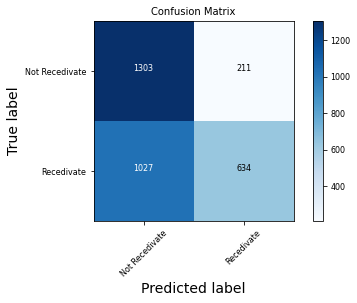

In [40]:
new_scores_african_american = new_scores[new_scores['race'] == 'African-American']
performance.accuracy_score(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'],normalize=True)

# performance.confusion_matrix(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'])
plot_conf_matrix(new_scores_african_american['two_year_recid'], new_scores_african_american['decile_score'], class_names=['Not Recedivate', 'Recedivate'] )

####Confusion Matrix - Caucasian

plotting the Confusion Matrix
CCR = 0.6571564431764146
Precision = 0.6876967846579525
Recall = 0.5747306221758777
[[1220   61]
 [ 660  162]]


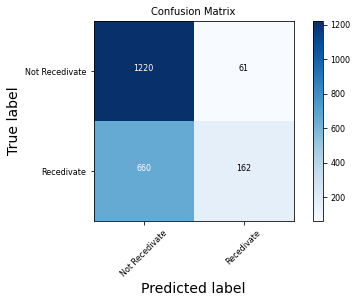

In [41]:
new_scores_Caucasian = new_scores[new_scores['race'] == 'Caucasian']
# performance.accuracy_score(new_scores_Caucasian['two_year_recid'],new_scores_Caucasian['decile_score'],normalize=True)
plot_conf_matrix(new_scores_Caucasian.two_year_recid, new_scores_Caucasian.decile_score, class_names=['Not Recedivate', 'Recedivate'])

#### Confusion Matrix - Female

plotting the Confusion Matrix
CCR = 0.6868085106382978
Precision = 0.6706947175082781
Recall = 0.5838671649094711
[[709  53]
 [315  98]]


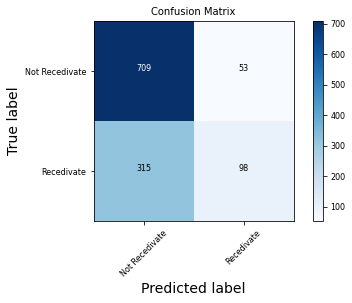

In [42]:
new_scores_female = new_scores[new_scores['sex'] == 'Female']
plot_conf_matrix(new_scores_female.two_year_recid, new_scores_female.decile_score, class_names=['Not Recedivate', 'Recedivate'])

####Confusion Matrix - Male

plotting the Confusion Matrix
CCR = 0.6215729437662597
Precision = 0.6714706491896825
Recall = 0.6093971337593926
[[2357  244]
 [1647  749]]


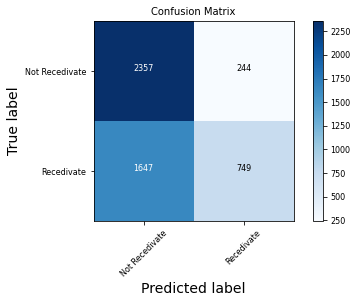

In [43]:
new_scores_male = new_scores[new_scores['sex'] == 'Male']
plot_conf_matrix(new_scores_male.two_year_recid, new_scores_male.decile_score, class_names=['Not Recedivate', 'Recedivate'])

Next, we examine the results of running three simple classifiers on the COMPAS data

### SVM


In [44]:
from sklearn.svm import SVC
svm_classifier = SVC(gamma=0.001, C=100.)
svm_classifier.fit(dataset_conditioned_train.features, dataset_conditioned_train.labels.ravel())

pred = svm_classifier.predict(dataset_conditioned_validate_test.features)

print('Accuracy of the SVM on testing set {0:.2f}% '
      .format(performance.accuracy_score(dataset_conditioned_validate_test.labels, pred, normalize=True)*100))


Accuracy of the SVM on testing set 64.46% 


#### Confusion Matrix for African Americans

plotting the Confusion Matrix
CCR = 0.6492146596858639
Precision = 0.652818721112203
Recall = 0.6473876340406115
[[260 208]
 [127 360]]


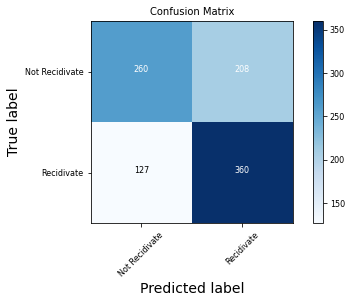

In [45]:
african_american_prediction = svm_classifier.predict(african_american_samples)
plot_conf_matrix(african_american_samples_label.to_numpy().ravel(), african_american_prediction, class_names=['Not Recidivate', 'Recidivate'] )


#### Confusion Matrix for Caucasians

plotting the Confusion Matrix
CCR = 0.6375198728139905
Precision = 0.6256913746342923
Recall = 0.6221616853466169
[[262 103]
 [125 139]]


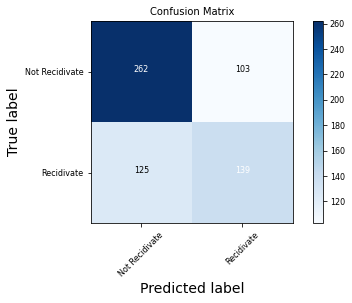

In [46]:
caucasian_prediction = svm_classifier.predict(caucasian_samples)
plot_conf_matrix(caucasian_samples_label.to_numpy().ravel(), caucasian_prediction, class_names=['Not Recidivate', 'Recidivate'])


####Confusion Matrix for Females

plotting the Confusion Matrix
CCR = 0.6306306306306306
Precision = 0.6056083220262325
Recall = 0.6100290583523129
[[146  68]
 [ 55  64]]


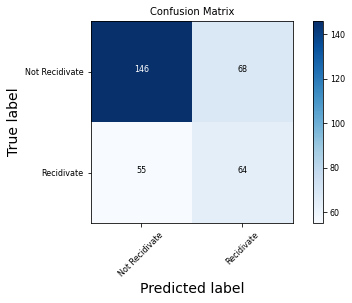

In [47]:
female_prediction = svm_classifier.predict(female_samples)
plot_conf_matrix(female_samples_label.to_numpy().ravel(), female_prediction, class_names=['Not Recidivate', 'Recidivate'])

####Confusion Matrix for Males

plotting the Confusion Matrix
CCR = 0.64828137490008
Precision = 0.6488941914160836
Recall = 0.6478612400564405
[[376 243]
 [197 435]]


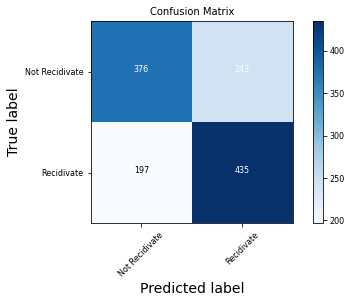

In [48]:
male_prediction = svm_classifier.predict(male_samples)
plot_conf_matrix(male_samples_label.to_numpy().ravel(), male_prediction, class_names=['Not Recidivate', 'Recidivate'])

### **Question 3: What biases did the classifier show?**
After training and testing this SVM classifier, what did you notice about the results above? How did the confusion matrices from the output of the classifiers compare to those from the COMPAS data? What kinds of biases did both show? Answer these questions in the cell below

In general, the confusion matrix predicted that more African Americans would not recidivate than recidivate. It wrong predicted that African Americans would not reoffend. This is also seen in the confusion matrix for Caucasian samples- in general, the model was incorrect in predicting the correct amount of offenders that would actually reoffend.

The SVM classifier has a heavier bias towards predicting reoffense, but the accuracy was slightly lower than the confusion matrix. In general, the SVM on the testing set had a higher accuracy than the COMPAS, but still these discrepancies are noticeable. Both models showed an inherent bias in predicting increased reoffense in African Americans and lower reoffense in caucasians.


## Building fairer classifiers

### **Question 4: How can these classifiers be improved?**
What modifications can be made on the above classifiers that would result in fairer outcomes? Write some potential modifications in the cell below

We can modify the classifier and make it more fair by setting a different threshold for reoffense. The main idea here is that we want to further limit the occurance of false positives and negatives. If we modify the decile scores to create different thresholds of reoffense for the different groups, we may see a slightly more accurate classifier.

###**Question 5 - Implement a Fairer classifier**
Using your suggested modifications above, modify one of the simple classifiers in order to produce a fairer model. Implement this model and plot the resulting confusion matrices below

In [78]:
dataset_conditioned_train, dataset_conditioned_validate_test = dataset_conditioned.split([0.7], shuffle=True)

In [79]:
from sklearn.svm import SVC
svm_classifier = SVC(gamma=0.001, C=100.)
svm_classifier.fit(dataset_conditioned_train.features, dataset_conditioned_train.labels.ravel())

pred = svm_classifier.predict(dataset_conditioned_validate_test.features)

print('Accuracy of the SVM on testing set {0:.2f}% '
      .format(performance.accuracy_score(dataset_conditioned_validate_test.labels, pred, normalize=True)*100))

Accuracy of the SVM on testing set 65.09% 


In [80]:
new_scores = dataset.copy()
new_scores_african_american = new_scores[new_scores['race'] == 'African-American']
new_scores_african_american['decile_score'].replace(to_replace=range(1,8),value=0,inplace=True)
new_scores_african_american['decile_score'].replace(to_replace=range(8,11),value=1,inplace=True)

new_scores_Caucasian = new_scores[new_scores['race'] == 'Caucasian'] 
new_scores_Caucasian['decile_score'].replace(to_replace=range(1,7),value=0,inplace=True)
new_scores_Caucasian['decile_score'].replace(to_replace=range(7,11),value=1,inplace=True)

new_scores_female = new_scores[new_scores['sex'] == 'Female']
new_scores_female['decile_score'].replace(to_replace=range(1,9),value=0,inplace=True)
new_scores_female['decile_score'].replace(to_replace=range(9,11),value=1,inplace=True)

new_scores_male = new_scores[new_scores['sex'] == 'Male']
new_scores_male['decile_score'].replace(to_replace=range(1,8),value=0,inplace=True)
new_scores_male['decile_score'].replace(to_replace=range(8,11),value=1,inplace=True)

In [81]:
print('size of traning and testing samples')
dataset_conditioned_train.convert_to_dataframe()[0].shape,dataset_conditioned_validate_test.convert_to_dataframe()[0].shape

size of traning and testing samples


((3694, 11), (1584, 11))

In [82]:
test_df = dataset_conditioned_validate_test.convert_to_dataframe()[0]

In [86]:
female_samples = test_df[test_df['sex'] == 1.0]
female_samples_label = female_samples.filter(['two_year_recid'])
female_samples.drop(columns=['two_year_recid'],inplace=True)

male_samples = test_df[test_df['sex'] == 0.0]
male_samples_label = male_samples.filter(['two_year_recid'])
male_samples.drop(columns=['two_year_recid'],inplace=True)

#get caucasians samples from the dataset
caucasian_samples = test_df[test_df['race'] == 1.0]
caucasian_samples_label = caucasian_samples.filter(['two_year_recid'])
caucasian_samples.drop(columns=['two_year_recid'],inplace=True)

#get african american samples from the dataset
african_american_samples = test_df[test_df['race'] == 0.0]
african_american_samples_label = african_american_samples.filter(['two_year_recid'])
african_american_samples.drop(columns=['two_year_recid'],inplace=True)
print('Number of African American samples in test set: {0}, number of Caucasian samples in test set: {1}'.format(african_american_samples.shape, caucasian_samples.shape))

Number of African American samples in test set: (950, 10), number of Caucasian samples in test set: (634, 10)


In [87]:
overall_accuracy = performance.accuracy_score(new_scores['two_year_recid'], new_scores['decile_score'],normalize=True)

print('COMPAS overall performance against the true labels: {0:3f}%'.format(overall_accuracy *100))

COMPAS overall performance against the true labels: 4.488010%


plotting the Confusion Matrix
CCR = 0.6497220015885623
Precision = 0.6528496411962179
Recall = 0.6502990611750454
[[371 264]
 [177 447]]


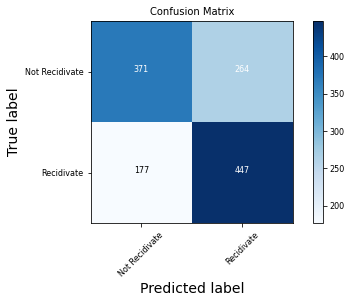

In [88]:
male_prediction = svm_classifier.predict(male_samples)
plot_conf_matrix(male_samples_label.to_numpy().ravel(), male_prediction, class_names=['Not Recidivate', 'Recidivate'])

plotting the Confusion Matrix
CCR = 0.6553846153846153
Precision = 0.6368150416077877
Recall = 0.6407373011386579
[[142  61]
 [ 51  71]]


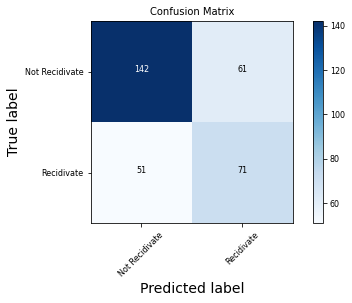

In [90]:
female_prediction = svm_classifier.predict(female_samples)
plot_conf_matrix(female_samples_label.to_numpy().ravel(), female_prediction, class_names=['Not Recidivate', 'Recidivate'])

plotting the Confusion Matrix
CCR = 0.6100787401574803
Precision = 0.6547616628996622
Recall = 0.6211659271642475
[[1303  211]
 [1027  634]]


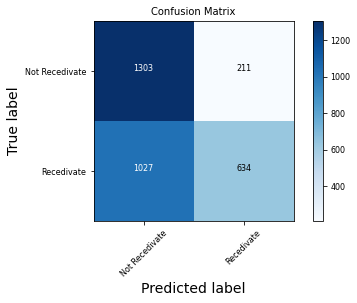

In [68]:
caucasian_prediction = svm_classifier.predict(caucasian_samples)
plot_conf_matrix(caucasian_samples_label.to_numpy().ravel(), caucasian_prediction, class_names=['Not Recidivate', 'Recidivate'])

plotting the Confusion Matrix
CCR = 0.6557894736842105
Precision = 0.660072276864252
Recall = 0.6492222222222223
[[236 214]
 [113 387]]


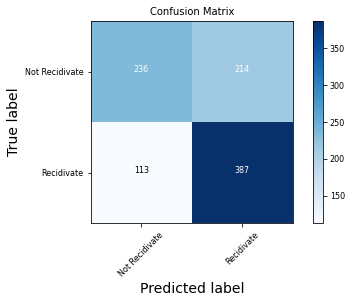

In [91]:
african_american_prediction = svm_classifier.predict(african_american_samples)
plot_conf_matrix(african_american_samples_label.to_numpy().ravel(), african_american_prediction, class_names=['Not Recidivate', 'Recidivate'])

###**Extra Credit: Implement a deep learning based model**
For extra credit, implement a fair deep learning based model in the cell below and measure its performance using confusion matrices (you can add extra cells if needed). How did its results compare to those of the fair SVM classifier? Write a one-sentence analysis of the results
